# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [33]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [25]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img



The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


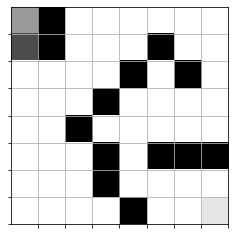

In [34]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [9]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [10]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [11]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [20]:
def get_free_cell(maze):
    return random.choice(qmaze.free_cells)

def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    for epoch in range(n_epoch):
        loss = 0
        
        pirate_cell = get_free_cell(maze)
        qmaze.reset(pirate_cell)
        
        envstate = qmaze.observe()
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
             # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(qmaze.valid_actions())
            else:
                action = np.argmax(experience.predict(envstate))
            envstate, reward, game_status = qmaze.act(action)
            
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            
            inputs, outputs = experience.get_data()
            history = model.fit(inputs, outputs, epochs = 8, batch_size = 24, verbose=0)
            loss = model.evaluate(inputs, outputs)
            if game_status == 'win':
                win_history.append(1)
            if game_status == 'lose':
                win_history.append(0)
                
        n_episodes = len(experience.memory)
        if len(win_history) > 0:
            win_rate = sum(win_history)/len(win_history)
        else:
            win_rate = 0.0
            
        print("\n\n\n")
        sum(win_history)
        print(win_rate)
        print("\n\n\n")

    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

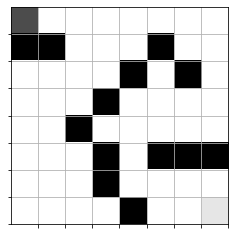

In [30]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [21]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

10/10 [==============================] - 0s 0us/step




0.0




Epoch: 000/14999 | Loss: 0.0000 | Episodes: 137 | Win count: 0 | Win rate: 0.000 | time: 2.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5




Epoch: 001/14999 | Loss: 0.0001 | Episodes: 259 | Win count: 1 | Win rate: 0.500 | time: 4.5 seconds
10/10 [==============================] - 0s 0us/step




0.6666666666666666




Epoch: 002/14999 | Loss: 0.0012 | Episodes: 302 | Win count: 2 | Win rate: 0.667 | time: 5.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5




Epoch: 003/14999 | Loss: 0.0000 | Episodes: 433 | Win count: 2 | Win rate: 0.500 | time: 7.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.6




Epoch: 004/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 3 | Win rate: 0.600 | time: 8.9 seconds
10/10 [==============================] - 0s 102us/step




0.6666666666666666




Epoch: 005/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 4 | Win rate: 0.667 | time: 9.6 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step




0.7142857142857143




Epoch: 006/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 5 | Win rate: 0.714 | time: 9.7 seconds
10/10 [==============================] - 0s 101us/step




0.625




Epoch: 007/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 5 | Win rate: 0.625 | time: 11.7 seconds
10/10 [==============================] - 0s 0us/step




0.6666666666666666




Epoch: 008/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 6 | Win rate: 0.667 | time: 11.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.6




Epoch: 009/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 6 | Win rate: 0.600 | time: 13.9 seconds
10/10 [==============================] - 0s 0us/step




0.6363636363636364




Epoch: 010/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 7 | Win rate: 0.636 | time: 14.0 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step




0.6666666666666666




Epoch: 011/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 8 | Win rate: 0.667 | time: 14.5 seconds
10/10 [==============================] - 0s 0us/step




0.6923076923076923




Epoch: 012/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 9 | Win rate: 0.692 | time: 14.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.6428571428571429




Epoch: 013/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 9 | Win rate: 0.643 | time: 17.0 seconds
10/10 [==============================] - 0s 0us/step




0.6666666666666666




Epoch: 014/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 10 | Win rate: 0.667 | time: 17.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.625




Epoch: 015/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 10 | Win rate: 0.625 | time: 19.6 seconds
10/10 [==============================] - 0s 0us/step




0.6470588235294118




Epoch: 016/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 11 | Win rate: 0.647 | time: 19.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.6111111111111112




Epoch: 017/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 11 | Win rate: 0.611 | time: 21.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5789473684210527




Epoch: 018/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 11 | Win rate: 0.579 | time: 23.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.55




Epoch: 019/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 11 | Win rate: 0.550 | time: 25.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5238095238095238




Epoch: 020/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 11 | Win rate: 0.524 | time: 28.0 seconds
10/10 [==============================] - 0s 89us/step


10/10 [==============================] - 0s 0us/step




0.5




Epoch: 021/14999 | Loss: 0.0018 | Episodes: 512 | Win count: 11 | Win rate: 0.500 | time: 30.2 seconds
10/10 [==============================] - 0s 0us/step




0.5217391304347826




Epoch: 022/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 12 | Win rate: 0.522 | time: 30.5 seconds
10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 1ms/step




0.5




Epoch: 023/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 12 | Win rate: 0.500 | time: 32.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step




0.48




Epoch: 024/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 12 | Win rate: 0.480 | time: 34.8 seconds
10/10 [==============================] - 0s 0us/step




0.5




Epoch: 025/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 13 | Win rate: 0.500 | time: 34.8 seconds
10/10 [==============================] - 0s 0us/step




0.5185185185185185




Epoch: 026/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 14 | Win rate: 0.519 | time: 35.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5




Epoch: 027/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 14 | Win rate: 0.500 | time: 37.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.4827586206896552




Epoch: 028/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 14 | Win rate: 0.483 | time: 39.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.4666666666666667




Epoch: 029/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 14 | Win rate: 0.467 | time: 41.3 seconds
10/10 [==============================] - 0s 0us/step




0.4838709677419355




Epoch: 030/14999 | Loss: 0.0000 | Episodes: 512 | Win count: 15 | Win rate: 0.484 | time: 41.3 seconds
10/10 [==============================] - 0s 0us/step






0.5




Epoch: 031/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 16 | Win rate: 0.500 | time: 43.3 seconds
10/10 [==============================] - 0s 0us/step




0.5151515151515151




Epoch: 032/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 17 | Win rate: 0.515 | time: 43.5 seconds
10/10 [==============================] - 0s 100us/step






0.5




Epoch: 033/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 17 | Win rate: 0.500 | time: 45.5 seconds
10/10 [==============================] - 0s 0us/step




0.4857142857142857




Epoch: 034/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 17 | Win rate: 0.486 | time: 47.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5




Epoch: 035/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 18 | Win rate: 0.500 | time: 48.3 seconds
10/10 [==============================] - 0s 0us/step




0.5135135135135135




Epoch: 036/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 19 | Win rate: 0.514 | time: 48.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5




Epoch: 037/14999 | Loss: 0.0347 | Episodes: 512 | Win count: 19 | Win rate: 0.500 | time: 50.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.48717948717948717




Epoch: 038/14999 | Loss: 0.0016 | Episodes: 512 | Win count: 19 | Win rate: 0.487 | time: 52.6 seconds
10/10 [==============================] - 0s 99us/step




0.5




Epoch: 039/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 20 | Win rate: 0.500 | time: 53.0 seconds
10/10 [==============================] - 0s 99us/step




0.5121951219512195




Epoch: 040/14999 | Loss: 0.0022 | Episodes: 512 | Win count: 21 | Win rate: 0.512 | time: 53.1 seconds
10/10 [==============================] - 0s 0us/step




0.5238095238095238




Epoch: 041/14999 | Loss: 0.0012 | Episodes: 512 | Win count: 22 | Win rate: 0.524 | time: 54.1 seconds
10/10 [==============================] - 0s 0us/step




0.5348837209302325




Epoch: 042/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 23 | Win rate: 0.535 | time: 54.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5227272727272727




Epoch: 043/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 23 | Win rate: 0.523 | time: 56.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5333333333333333




Epoch: 044/14999 | Loss: 0.0016 | Episodes: 512 | Win count: 24 | Win rate: 0.533 | time: 57.3 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 100us/step




0.5217391304347826




Epoch: 045/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 24 | Win rate: 0.522 | time: 59.4 seconds
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 101us/step




0.5106382978723404




Epoch: 046/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 24 | Win rate: 0.511 | time: 61.6 seconds
10/10 [==============================] - 0s 0us/step




0.5208333333333334




Epoch: 047/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 25 | Win rate: 0.521 | time: 61.8 seconds
10/10 [==============================] - 0s 0us/step




0.5306122448979592




Epoch: 048/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 26 | Win rate: 0.531 | time: 61.8 seconds
10/10 [==============================] - 0s 99us/step




0.54




Epoch: 049/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 27 | Win rate: 0.540 | time: 61.9 seconds
10/10 [==============================] - 0s 0us/step




0.5490196078431373




Epoch: 050/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 28 | Win rate: 0.549 | time: 62.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5384615384615384




Epoch: 051/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 28 | Win rate: 0.538 | time: 64.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5283018867924528




Epoch: 052/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 28 | Win rate: 0.528 | time: 66.6 seconds
10/10 [==============================] - 0s 100us/step




0.5370370370370371




Epoch: 053/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 29 | Win rate: 0.537 | time: 66.6 seconds
10/10 [==============================] - 0s 102us/step




0.5454545454545454




Epoch: 054/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 30 | Win rate: 0.545 | time: 67.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5357142857142857




Epoch: 055/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 30 | Win rate: 0.536 | time: 69.4 seconds
10/10 [==============================] - 0s 101us/step




0.543859649122807




Epoch: 056/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 31 | Win rate: 0.544 | time: 69.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step




0.5344827586206896




Epoch: 057/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 31 | Win rate: 0.534 | time: 71.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5254237288135594




Epoch: 058/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 31 | Win rate: 0.525 | time: 73.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5166666666666667




Epoch: 059/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 31 | Win rate: 0.517 | time: 75.8 seconds
10/10 [==============================] - 0s 0us/step




0.5245901639344263




Epoch: 060/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 32 | Win rate: 0.525 | time: 75.9 seconds
10/10 [==============================] - 0s 0us/step




0.532258064516129




Epoch: 061/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 33 | Win rate: 0.532 | time: 76.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5396825396825397




Epoch: 062/14999 | Loss: 0.0018 | Episodes: 512 | Win count: 34 | Win rate: 0.540 | time: 76.8 seconds
10/10 [==============================] - 0s 72us/step




0.546875




Epoch: 063/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 35 | Win rate: 0.547 | time: 77.5 seconds
10/10 [==============================] - 0s 43us/step


10/10 [==============================] - 0s 100us/step




0.5384615384615384




Epoch: 064/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 35 | Win rate: 0.538 | time: 79.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5303030303030303




Epoch: 065/14999 | Loss: 0.0016 | Episodes: 512 | Win count: 35 | Win rate: 0.530 | time: 81.6 seconds
10/10 [==============================] - 0s 0us/step




0.5373134328358209




Epoch: 066/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 36 | Win rate: 0.537 | time: 81.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5294117647058824




Epoch: 067/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 36 | Win rate: 0.529 | time: 83.8 seconds
10/10 [==============================] - 0s 0us/step




0.5362318840579711




Epoch: 068/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 37 | Win rate: 0.536 | time: 84.0 seconds
10/10 [==============================] - 0s 100us/step




0.5428571428571428




Epoch: 069/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 38 | Win rate: 0.543 | time: 84.2 seconds
10/10 [==============================] - 0s 0us/step




0.5492957746478874




Epoch: 070/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 39 | Win rate: 0.549 | time: 84.4 seconds
10/10 [==============================] - 0s 0us/step




0.5555555555555556




Epoch: 071/14999 | Loss: 0.0019 | Episodes: 512 | Win count: 40 | Win rate: 0.556 | time: 84.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 99us/step




0.547945205479452




Epoch: 072/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 40 | Win rate: 0.548 | time: 86.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5405405405405406




Epoch: 073/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 40 | Win rate: 0.541 | time: 88.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5333333333333333




Epoch: 074/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 40 | Win rate: 0.533 | time: 91.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5263157894736842




Epoch: 075/14999 | Loss: 0.0034 | Episodes: 512 | Win count: 40 | Win rate: 0.526 | time: 93.1 seconds
10/10 [==============================] - 0s 0us/step




0.5324675324675324




Epoch: 076/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 41 | Win rate: 0.532 | time: 94.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5256410256410257




Epoch: 077/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 41 | Win rate: 0.526 | time: 96.2 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5316455696202531




Epoch: 078/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 42 | Win rate: 0.532 | time: 97.9 seconds
10/10 [==============================] - 0s 0us/step




0.5375




Epoch: 079/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 43 | Win rate: 0.537 | time: 98.1 seconds
10/10 [==============================] - 0s 0us/step




0.5432098765432098




Epoch: 080/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 44 | Win rate: 0.543 | time: 98.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5365853658536586




Epoch: 081/14999 | Loss: 0.0027 | Episodes: 512 | Win count: 44 | Win rate: 0.537 | time: 100.4 seconds
10/10 [==============================] - 0s 0us/step




0.5421686746987951




Epoch: 082/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 45 | Win rate: 0.542 | time: 100.4 seconds
10/10 [==============================] - 0s 0us/step




0.5476190476190477




Epoch: 083/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 46 | Win rate: 0.548 | time: 100.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5411764705882353




Epoch: 084/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 46 | Win rate: 0.541 | time: 102.7 seconds
10/10 [==============================] - 0s 39us/step


10/10 [==============================] - 0s 0us/step




0.5348837209302325




Epoch: 085/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 46 | Win rate: 0.535 | time: 104.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5287356321839081




Epoch: 086/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 46 | Win rate: 0.529 | time: 107.1 seconds
10/10 [==============================] - 0s 0us/step




0.5340909090909091




Epoch: 087/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 47 | Win rate: 0.534 | time: 107.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step




0.5280898876404494




Epoch: 088/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 47 | Win rate: 0.528 | time: 109.9 seconds
10/10 [==============================] - 0s 0us/step




0.5333333333333333




Epoch: 089/14999 | Loss: 0.0016 | Episodes: 512 | Win count: 48 | Win rate: 0.533 | time: 109.9 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5274725274725275




Epoch: 090/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 48 | Win rate: 0.527 | time: 112.0 seconds
10/10 [==============================] - 0s 0us/step




0.532608695652174




Epoch: 091/14999 | Loss: 0.0022 | Episodes: 512 | Win count: 49 | Win rate: 0.533 | time: 112.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5376344086021505




Epoch: 092/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 50 | Win rate: 0.538 | time: 113.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5425531914893617




Epoch: 093/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 51 | Win rate: 0.543 | time: 115.2 seconds
10/10 [==============================] - 0s 0us/step




0.5473684210526316




Epoch: 094/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 52 | Win rate: 0.547 | time: 115.9 seconds
10/10 [==============================] - 0s 0us/step




0.5520833333333334




Epoch: 095/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 53 | Win rate: 0.552 | time: 116.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5463917525773195




Epoch: 096/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 53 | Win rate: 0.546 | time: 118.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5408163265306123




Epoch: 097/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 53 | Win rate: 0.541 | time: 120.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5353535353535354




Epoch: 098/14999 | Loss: 0.0012 | Episodes: 512 | Win count: 53 | Win rate: 0.535 | time: 122.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.53




Epoch: 099/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 53 | Win rate: 0.530 | time: 125.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5346534653465347




Epoch: 100/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 54 | Win rate: 0.535 | time: 126.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5294117647058824




Epoch: 101/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 54 | Win rate: 0.529 | time: 128.9 seconds
10/10 [==============================] - 0s 0us/step




0.5339805825242718




Epoch: 102/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 55 | Win rate: 0.534 | time: 129.1 seconds
10/10 [==============================] - 0s 0us/step




0.5384615384615384




Epoch: 103/14999 | Loss: 0.0017 | Episodes: 512 | Win count: 56 | Win rate: 0.538 | time: 130.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step




0.5428571428571428




Epoch: 104/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 57 | Win rate: 0.543 | time: 130.7 seconds
10/10 [==============================] - 0s 99us/step




0.5471698113207547




Epoch: 105/14999 | Loss: 0.0012 | Episodes: 512 | Win count: 58 | Win rate: 0.547 | time: 130.7 seconds
10/10 [==============================] - 0s 0us/step




0.5514018691588785




Epoch: 106/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 59 | Win rate: 0.551 | time: 131.2 seconds
10/10 [==============================] - 0s 87us/step




0.5555555555555556




Epoch: 107/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 60 | Win rate: 0.556 | time: 132.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 4us/step




0.5596330275229358




Epoch: 108/14999 | Loss: 0.0017 | Episodes: 512 | Win count: 61 | Win rate: 0.560 | time: 134.0 seconds
10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step




0.5545454545454546




Epoch: 109/14999 | Loss: 0.0021 | Episodes: 512 | Win count: 61 | Win rate: 0.555 | time: 136.0 seconds
10/10 [==============================] - 0s 100us/step




0.5585585585585585




Epoch: 110/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 62 | Win rate: 0.559 | time: 136.4 seconds
10/10 [==============================] - 0s 0us/step




0.5625




Epoch: 111/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 63 | Win rate: 0.562 | time: 137.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5663716814159292




Epoch: 112/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 64 | Win rate: 0.566 | time: 137.4 seconds
10/10 [==============================] - 0s 0us/step




0.5701754385964912




Epoch: 113/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 65 | Win rate: 0.570 | time: 137.5 seconds
10/10 [==============================] - 0s 99us/step




0.5739130434782609




Epoch: 114/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 66 | Win rate: 0.574 | time: 137.6 seconds
10/10 [==============================] - 0s 0us/step




0.5775862068965517




Epoch: 115/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 67 | Win rate: 0.578 | time: 138.0 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 101us/step




0.5726495726495726




Epoch: 116/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 67 | Win rate: 0.573 | time: 140.1 seconds
10/10 [==============================] - 0s 0us/step




0.576271186440678




Epoch: 117/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 68 | Win rate: 0.576 | time: 140.2 seconds
10/10 [==============================] - 0s 0us/step




0.5798319327731093




Epoch: 118/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 69 | Win rate: 0.580 | time: 140.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 99us/step




0.5833333333333334




Epoch: 119/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 70 | Win rate: 0.583 | time: 142.0 seconds
10/10 [==============================] - 0s 0us/step




0.5867768595041323




Epoch: 120/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 71 | Win rate: 0.587 | time: 142.1 seconds
10/10 [==============================] - 0s 0us/step




0.5901639344262295




Epoch: 121/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 72 | Win rate: 0.590 | time: 142.3 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5853658536585366




Epoch: 122/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 72 | Win rate: 0.585 | time: 144.4 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5887096774193549




Epoch: 123/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 73 | Win rate: 0.589 | time: 146.2 seconds
10/10 [==============================] - 0s 0us/step




0.592




Epoch: 124/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 74 | Win rate: 0.592 | time: 146.5 seconds
10/10 [==============================] - 0s 0us/step




0.5952380952380952




Epoch: 125/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 75 | Win rate: 0.595 | time: 147.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.5984251968503937




Epoch: 126/14999 | Loss: 0.0019 | Episodes: 512 | Win count: 76 | Win rate: 0.598 | time: 148.2 seconds
10/10 [==============================] - 0s 0us/step




0.6015625




Epoch: 127/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 77 | Win rate: 0.602 | time: 148.4 seconds
10/10 [==============================] - 0s 99us/step




0.6046511627906976




Epoch: 128/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 78 | Win rate: 0.605 | time: 148.8 seconds
10/10 [==============================] - 0s 0us/step




0.6076923076923076




Epoch: 129/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 79 | Win rate: 0.608 | time: 148.8 seconds
10/10 [==============================] - 0s 0us/step




0.6106870229007634




Epoch: 130/14999 | Loss: 0.0020 | Episodes: 512 | Win count: 80 | Win rate: 0.611 | time: 149.2 seconds
10/10 [==============================] - 0s 110us/step




0.6136363636363636




Epoch:

10/10 [==============================] - 0s 0us/step




0.6194029850746269




Epoch: 133/14999 | Loss: 0.0015 | Episodes: 512 | Win count: 83 | Win rate: 0.619 | time: 150.6 seconds
10/10 [==============================] - 0s 100us/step




0.6222222222222222




Epoch: 134/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 84 | Win rate: 0.622 | time: 150.8 seconds
10/10 [==============================] - 0s 0us/step




0.625




Epoch: 135/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 85 | Win rate: 0.625 | time: 151.6 seconds
10/10 [==============================] - 0s 0us/step




0.6277372262773723




Epoch: 136/14999 | Loss: 0.0018 | Episodes: 512 | Win count: 86 | Win rate: 0.628 | time: 151.7 seconds
10/10 [==============================] - 0s 100us/step




0.6304347826086957




Epoch: 137/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 87 | Win rate: 0.630 | time: 152.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.6330935251798561




Epoch: 138/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 88 | Win rate: 0.633 | time: 154.2 seconds
10/10 [==============================] - 0s 99us/step




0.6357142857142857




Epoch: 139/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 89 | Win rate: 0.636 | time: 154.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.6382978723404256




Epoch: 140/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 90 | Win rate: 0.638 | time: 154.6 seconds
10/10 [==============================] - 0s 0us/step




0.6408450704225352




Epoch: 141/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 91 | Win rate: 0.641 | time: 154.7 seconds
10/10 [==============================] - 0s 0us/step




0.6433566433566433




Epoch: 142/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 92 | Win rate: 0.643 | time: 155.3 seconds
10/10 [==============================] - 0s 0us/step




0.6458333333333334




Epoch: 143/14999 | Loss: 0.0012 | Episodes: 512 | Win count: 93 | Win rate: 0.646 | time: 155.5 seconds
10/10 [==============================] - 0s 0us/step




0.6482758620689655




Epoch: 144/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 94 | Win rate: 0.648 | time: 155.8 seconds
10/10 [==============================] - 0s 101us/step




0.6506849315068494








0.6530612244897959




Epoch: 146/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 96 | Win rate: 0.653 | time: 156.6 seconds
10/10 [==============================] - 0s 0us/step




0.6554054054054054




Epoch: 147/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 97 | Win rate: 0.655 | time: 157.0 seconds
10/10 [==============================] - 0s 102us/step




0.6577181208053692




Epoch: 148/14999 | Loss: 0.0012 | Episodes: 512 | Win count: 98 | Win rate: 0.658 | time: 157.5 seconds
10/10 [==============================] - 0s 0us/step




0.66




Epoch: 149/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 99 | Win rate: 0.660 | time: 157.8 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step




0.6622516556291391




Epoch: 150/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 100 | Win rate: 0.662 | time: 158.8 seconds
10/10 [==============================] - 0s 0us/step




0.6644736842105263




Epoch: 151/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 101 | Win rate: 0.664 | time: 158.9 seconds
10/10 [==============================] - 0s 0us/step




0.6666666666666666




Epoch: 152/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 102 | Win rate: 0.667 | time: 158.9 seconds
10/10 [==============================] - 0s 0us/step




0.6688311688311688




Epoch: 153/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 103 | Win rate: 0.669 | time: 159.4 seconds
10/10 [==============================] - 0s 100us/step




0.6709677419354839




Epoch: 154/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 104 | Win rate: 0.671 | time: 159.8 seconds
10/10 [==============================] - 0s 101us/step




0.6730769230

10/10 [==============================] - 0s 0us/step




0.68125




Epoch: 159/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 109 | Win rate: 0.681 | time: 161.3 seconds
10/10 [==============================] - 0s 0us/step




0.6832298136645962




Epoch: 160/14999 | Loss: 0.0023 | Episodes: 512 | Win count: 110 | Win rate: 0.683 | time: 161.7 seconds
10/10 [==============================] - 0s 0us/step




0.6851851851851852




Epoch: 161/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 111 | Win rate: 0.685 | time: 162.0 seconds
10/10 [==============================] - 0s 0us/step




0.6871165644171779




Epoch: 162/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 112 | Win rate: 0.687 | time: 162.6 seconds
10/10 [==============================] - 0s 0us/step




0.6890243902439024




Epoch: 163/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 113 | Win rate: 0.689 | time: 162.6 seconds
10/10 [==============================] - 0s 0us/step




0.6909090909090909




Epoch:

10/10 [==============================] - 0s 0us/step




0.6982248520710059




Epoch: 168/14999 | Loss: 0.0016 | Episodes: 512 | Win count: 118 | Win rate: 0.698 | time: 165.4 seconds
10/10 [==============================] - 0s 0us/step




0.7




Epoch: 169/14999 | Loss: 0.0012 | Episodes: 512 | Win count: 119 | Win rate: 0.700 | time: 165.8 seconds
10/10 [==============================] - 0s 0us/step




0.7017543859649122




Epoch: 170/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 120 | Win rate: 0.702 | time: 166.1 seconds
10/10 [==============================] - 0s 0us/step




0.7034883720930233




Epoch: 171/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 121 | Win rate: 0.703 | time: 166.5 seconds
10/10 [==============================] - 0s 0us/step




0.7052023121387283




Epoch: 172/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 122 | Win rate: 0.705 | time: 166.9 seconds
10/10 [==============================] - 0s 99us/step




0.7068965517241379




Epoch: 17

10/10 [==============================] - 0s 0us/step




0.7102272727272727




Epoch: 175/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 125 | Win rate: 0.710 | time: 168.0 seconds
10/10 [==============================] - 0s 0us/step




0.711864406779661




Epoch: 176/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 126 | Win rate: 0.712 | time: 168.2 seconds
10/10 [==============================] - 0s 0us/step




0.7134831460674157




Epoch: 177/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 127 | Win rate: 0.713 | time: 168.8 seconds
10/10 [==============================] - 0s 0us/step




0.7150837988826816




Epoch: 178/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 128 | Win rate: 0.715 | time: 169.2 seconds
10/10 [==============================] - 0s 0us/step




0.7166666666666667




Epoch: 179/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 129 | Win rate: 0.717 | time: 169.6 seconds
10/10 [==============================] - 0s 0us/step




0.7182320441988951






0.7197802197802198




Epoch: 181/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 131 | Win rate: 0.720 | time: 171.0 seconds
10/10 [==============================] - 0s 0us/step




0.7213114754098361




Epoch: 182/14999 | Loss: 0.0012 | Episodes: 512 | Win count: 132 | Win rate: 0.721 | time: 171.8 seconds
10/10 [==============================] - 0s 0us/step




0.7228260869565217




Epoch: 183/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 133 | Win rate: 0.723 | time: 172.2 seconds
10/10 [==============================] - 0s 0us/step




0.7243243243243244




Epoch: 184/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 134 | Win rate: 0.724 | time: 172.7 seconds
10/10 [==============================] - 0s 0us/step




0.7258064516129032




Epoch: 185/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 135 | Win rate: 0.726 | time: 173.1 seconds
10/10 [==============================] - 0s 0us/step




0.7272727272727273




Epoch: 186/14999 | Loss: 0.0002 | Episodes: 512 

10/10 [==============================] - 0s 0us/step




0.7287234042553191




Epoch: 187/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 137 | Win rate: 0.729 | time: 173.7 seconds
10/10 [==============================] - 0s 0us/step




0.7301587301587301




Epoch: 188/14999 | Loss: 0.0016 | Episodes: 512 | Win count: 138 | Win rate: 0.730 | time: 174.1 seconds
10/10 [==============================] - 0s 0us/step




0.7315789473684211




Epoch: 189/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 139 | Win rate: 0.732 | time: 174.6 seconds
10/10 [==============================] - 0s 0us/step




0.7329842931937173




Epoch: 190/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 140 | Win rate: 0.733 | time: 175.2 seconds
10/10 [==============================] - 0s 0us/step




0.734375




Epoch: 191/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 141 | Win rate: 0.734 | time: 176.0 seconds
10/10 [==============================] - 0s 0us/step




0.7357512953367875




Epoch

10/10 [==============================] - 0s 0us/step




0.7371134020618557




Epoch: 193/14999 | Loss: 0.0015 | Episodes: 512 | Win count: 143 | Win rate: 0.737 | time: 176.3 seconds
10/10 [==============================] - 0s 0us/step




0.7384615384615385




Epoch: 194/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 144 | Win rate: 0.738 | time: 176.5 seconds
10/10 [==============================] - 0s 0us/step




0.7397959183673469




Epoch: 195/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 145 | Win rate: 0.740 | time: 176.7 seconds
10/10 [==============================] - 0s 0us/step




0.7411167512690355




Epoch: 196/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 146 | Win rate: 0.741 | time: 177.3 seconds
10/10 [==============================] - 0s 0us/step




0.7424242424242424




Epoch: 197/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 147 | Win rate: 0.742 | time: 177.7 seconds
10/10 [==============================] - 0s 0us/step




0.7437185929648241

10/10 [==============================] - 0s 0us/step




0.745




Epoch: 199/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 149 | Win rate: 0.745 | time: 178.8 seconds
10/10 [==============================] - 0s 0us/step




0.746268656716418




Epoch: 200/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 150 | Win rate: 0.746 | time: 179.5 seconds
10/10 [==============================] - 0s 98us/step




0.7475247524752475




Epoch: 201/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 151 | Win rate: 0.748 | time: 179.9 seconds
10/10 [==============================] - 0s 0us/step




0.7487684729064039




Epoch: 202/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 152 | Win rate: 0.749 | time: 180.2 seconds
10/10 [==============================] - 0s 0us/step




0.75




Epoch: 203/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 153 | Win rate: 0.750 | time: 181.0 seconds
10/10 [==============================] - 0s 0us/step




0.751219512195122




Epoch: 204/14999 | Loss

10/10 [==============================] - 0s 0us/step




0.7524271844660194




Epoch: 205/14999 | Loss: 0.0015 | Episodes: 512 | Win count: 155 | Win rate: 0.752 | time: 181.9 seconds
10/10 [==============================] - 0s 99us/step




0.7536231884057971




Epoch: 206/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 156 | Win rate: 0.754 | time: 182.4 seconds
10/10 [==============================] - 0s 98us/step




0.7548076923076923




Epoch: 207/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 157 | Win rate: 0.755 | time: 183.0 seconds
10/10 [==============================] - 0s 0us/step




0.7559808612440191




Epoch: 208/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 158 | Win rate: 0.756 | time: 183.6 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 102us/step




0.7571428571428571




Epoch: 209/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 159 | Win rate: 0.757 | time: 184.2 seconds
10/10 [==============================] - 0s 278us/step




0.7582938388625592




Epoch: 210/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 160 | Win rate: 0.758 | time: 184.4 seconds
10/10 [==============================] - 0s 0us/step




0.7594339622641509




Epoch: 211/14999 | Loss: 0.0015 | Episodes: 512 | Win count: 161 | Win rate: 0.759 | time: 184.6 seconds
10/10 [==============================] - 0s 0us/step




0.7605633802816901




Epoch: 212/14999 | Loss: 0.0011 | Episodes: 512 | Win count: 162 | Win rate: 0.761 | time: 184.7 seconds
10/10 [==============================] - 0s 0us/step




0.7616822429906542




Epoch: 213/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 163 | Win rate: 0.762 | time: 184.9 seconds
10/10 [==============================] - 0s 0us/step




0.762790697674

10/10 [==============================] - 0s 0us/step




0.7681818181818182




Epoch: 219/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 169 | Win rate: 0.768 | time: 186.4 seconds
10/10 [==============================] - 0s 0us/step




0.7692307692307693




Epoch: 220/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 170 | Win rate: 0.769 | time: 187.5 seconds
10/10 [==============================] - 0s 0us/step




0.7702702702702703




Epoch: 221/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 171 | Win rate: 0.770 | time: 188.2 seconds
10/10 [==============================] - 0s 0us/step




0.7713004484304933




Epoch: 222/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 172 | Win rate: 0.771 | time: 188.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.7723214285714286




Epoch: 223/14999 | Loss: 0.0015 | Episodes: 512 | Win count: 173 | Win rate: 0.772 | time: 189.0 seconds
10/10 [==============================] - 0s 0us/step




0.7733333333333333




Epoch: 224/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 174 | Win rate: 0.773 | time: 189.5 seconds
10/10 [==============================] - 0s 0us/step




0.7743362831858407




Epoch: 225/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 175 | Win rate: 0.774 | time: 190.1 seconds
10/10 [==============================] - 0s 0us/step




0.775330396475771




Epoch: 226/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 176 | Win rate: 0.775 | time: 190.5 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.7763157894736842




Epoch: 227/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 177 | Win rate: 0.776 | time: 191.0 seconds
10/10 [==============================] - 0s 0us/step




0.777292576419214




Epoch: 228/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 178 | Win rate: 0.777 | time: 191.2 seconds
10/10 [==============================] - 0s 0us/step




0.7782608695652173




Epoch: 229/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 179 | Win rate: 0.778 | time: 191.3 seconds
10/10 [==============================] - 0s 0us/step




0.7792207792207793




Epoch: 230/14999 | Loss: 0.0015 | Episodes: 512 | Win count: 180 | Win rate: 0.779 | time: 191.4 seconds
10/10 [==============================] - 0s 0us/step




0.7801724137931034




Epoch: 231/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 181 | Win rate: 0.780 | time: 191.6 seconds
10/10 [==============================] - 0s 0us/step




0.7811158798283262


10/10 [==============================] - 0s 0us/step




0.7848101265822784




Epoch: 236/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 186 | Win rate: 0.785 | time: 193.9 seconds
10/10 [==============================] - 0s 100us/step




0.7857142857142857




Epoch: 237/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 187 | Win rate: 0.786 | time: 194.4 seconds
10/10 [==============================] - 0s 100us/step




0.7866108786610879




Epoch: 238/14999 | Loss: 0.0014 | Episodes: 512 | Win count: 188 | Win rate: 0.787 | time: 194.9 seconds
10/10 [==============================] - 0s 3us/step




0.7875




Epoch: 239/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 189 | Win rate: 0.787 | time: 195.6 seconds
10/10 [==============================] - 0s 102us/step




0.7883817427385892




Epoch: 240/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 190 | Win rate: 0.788 | time: 195.6 seconds
10/10 [==============================] - 0s 0us/step




0.7892561983471075




E

10/10 [==============================] - 0s 0us/step




0.7918367346938775




Epoch: 244/14999 | Loss: 0.0012 | Episodes: 512 | Win count: 194 | Win rate: 0.792 | time: 197.0 seconds
10/10 [==============================] - 0s 0us/step




0.7926829268292683




Epoch: 245/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 195 | Win rate: 0.793 | time: 197.3 seconds
10/10 [==============================] - 0s 0us/step




0.7935222672064778




Epoch: 246/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 196 | Win rate: 0.794 | time: 197.7 seconds
10/10 [==============================] - 0s 0us/step




0.7943548387096774




Epoch: 247/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 197 | Win rate: 0.794 | time: 198.1 seconds
10/10 [==============================] - 0s 0us/step




0.7951807228915663




Epoch: 248/14999 | Loss: 0.0006 | Episodes: 512 | Win count: 198 | Win rate: 0.795 | time: 198.2 seconds
10/10 [==============================] - 0s 0us/step




0.796




Epoch: 2

10/10 [==============================] - 0s 0us/step




0.7976190476190477




Epoch: 251/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 201 | Win rate: 0.798 | time: 199.7 seconds
10/10 [==============================] - 0s 0us/step




0.7984189723320159




Epoch: 252/14999 | Loss: 0.0013 | Episodes: 512 | Win count: 202 | Win rate: 0.798 | time: 200.2 seconds
10/10 [==============================] - 0s 98us/step




0.7992125984251969




Epoch: 253/14999 | Loss: 0.0021 | Episodes: 512 | Win count: 203 | Win rate: 0.799 | time: 200.5 seconds
10/10 [==============================] - 0s 0us/step




0.8




Epoch: 254/14999 | Loss: 0.0016 | Episodes: 512 | Win count: 204 | Win rate: 0.800 | time: 200.9 seconds
10/10 [==============================] - 0s 0us/step




0.80078125




Epoch: 255/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 205 | Win rate: 0.801 | time: 201.6 seconds
10/10 [==============================] - 0s 0us/step




0.8015564202334631




Epoch: 256/14999 

10/10 [==============================] - 0s 99us/step




0.8023255813953488




Epoch: 257/14999 | Loss: 0.0005 | Episodes: 512 | Win count: 207 | Win rate: 0.802 | time: 202.9 seconds
10/10 [==============================] - 0s 0us/step




0.803088803088803




Epoch: 258/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 208 | Win rate: 0.803 | time: 203.3 seconds
10/10 [==============================] - 0s 0us/step




0.8038461538461539




Epoch: 259/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 209 | Win rate: 0.804 | time: 203.6 seconds
10/10 [==============================] - 0s 0us/step




0.8045977011494253




Epoch: 260/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 210 | Win rate: 0.805 | time: 203.7 seconds
10/10 [==============================] - 0s 0us/step




0.8053435114503816




Epoch: 261/14999 | Loss: 0.0007 | Episodes: 512 | Win count: 211 | Win rate: 0.805 | time: 204.0 seconds
10/10 [==============================] - 0s 0us/step




0.8060836501901141

10/10 [==============================] - 0s 0us/step




0.8075471698113208




Epoch: 264/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 214 | Win rate: 0.808 | time: 205.4 seconds
10/10 [==============================] - 0s 0us/step




0.8082706766917294




Epoch: 265/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 215 | Win rate: 0.808 | time: 205.7 seconds
10/10 [==============================] - 0s 100us/step




0.8089887640449438




Epoch: 266/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 216 | Win rate: 0.809 | time: 206.4 seconds
10/10 [==============================] - 0s 0us/step




0.8097014925373134




Epoch: 267/14999 | Loss: 0.0002 | Episodes: 512 | Win count: 217 | Win rate: 0.810 | time: 206.7 seconds
10/10 [==============================] - 0s 0us/step




0.8104089219330854




Epoch: 268/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 218 | Win rate: 0.810 | time: 207.1 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.8111111111111111




Epoch: 269/14999 | Loss: 0.0003 | Episodes: 512 | Win count: 219 | Win rate: 0.811 | time: 207.8 seconds
10/10 [==============================] - 0s 0us/step




0.8118081180811808




Epoch: 270/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 220 | Win rate: 0.812 | time: 208.5 seconds
10/10 [==============================] - 0s 0us/step




0.8125




Epoch: 271/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 221 | Win rate: 0.812 | time: 209.0 seconds
10/10 [==============================] - 0s 0us/step




0.8131868131868132




Epoch: 272/14999 | Loss: 0.0010 | Episodes: 512 | Win count: 222 | Win rate: 0.813 | time: 209.5 seconds
10/10 [==============================] - 0s 101us/step




0.8138686131386861




Epoch: 273/14999 | Loss: 0.0004 | Episodes: 512 | Win count: 223 | Win rate: 0.814 | time: 209.7 seconds
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step




0.8145454545454546




Epoch: 274/14999 | Loss: 0.0001 | Episodes: 512 | Win count: 224 | Win rate: 0.815 | time: 210.2 seconds
10/10 [==============================] - 0s 0us/step




0.8152173913043478




Epoch: 275/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 225 | Win rate: 0.815 | time: 210.6 seconds
10/10 [==============================] - 0s 0us/step




0.8158844765342961




Epoch: 276/14999 | Loss: 0.0019 | Episodes: 512 | Win count: 226 | Win rate: 0.816 | time: 210.8 seconds
10/10 [==============================] - 0s 0us/step




0.8165467625899281




Epoch: 277/14999 | Loss: 0.0008 | Episodes: 512 | Win count: 227 | Win rate: 0.817 | time: 211.1 seconds
10/10 [==============================] - 0s 0us/step




0.8172043010752689




Epoch: 278/14999 | Loss: 0.0009 | Episodes: 512 | Win count: 228 | Win rate: 0.817 | time: 211.2 seconds
10/10 [==============================] - 0s 0us/step




0.8178571428571428

212.194635

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

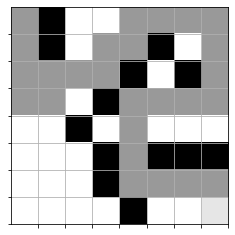

In [35]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.